In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import polars as pl



In [2]:
csv_path = Path(r"..\datasets\steam-games-dataset\games.csv")
if not csv_path.exists():
    raise FileNotFoundError("No se encontró 'games.csv' en el directorio actual")
games = pd.read_csv(csv_path, index_col=False)

In [3]:
games.head(4)

,AppID,Name,Release_date,Estimated_owners,Peak_CCU,Required_age,Price,DiscountDLC_count,IDK,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,2539430,Black Dragon Mage Playtest,"Aug 1, 2023",0 - 0,0,0,0.00,0,0,NaN,[],[],NaN,https://shared.akamai.steamstatic.com/store_it...,NaN,NaN,NaN,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,https://shared.akamai.steamstatic.com/store_it...,NaN
1,496350,Supipara - Chapter 1 Spring Has Come!,"Jul 29, 2016",0 - 20000,0,0,5.24,65,0,"Springtime, April: when the cherry trees come ...",['English'],[],NaN,https://shared.akamai.steamstatic.com/store_it...,http://mangagamer.org/supipara,http://mangagamer.com,support@mangagamer.com,True,False,False,0,NaN,0,252,3,NaN,0,231,NaN,8,0,8,0,minori,MangaGamer,"Single-player,Steam Trading Cards,Steam Cloud,...",Adventure,"Adventure,Visual Novel,Anime,Cute",https://shared.akamai.steamstatic.com/store_it...,NaN
2,1034400,Mystery Solitaire The Black Raven,"May 6, 2019",0 - 20000,0,0,4.99,0,0,"Immerse yourself in the most beloved, mystical...","['English', 'French', 'German', 'Russian']",[],NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.facebook.com/8FloorGames/,https://www.facebook.com/8FloorGames,support@8floor.net,True,True,False,0,NaN,0,21,3,NaN,0,0,NaN,0,0,0,0,Somer Games,8floor,"Single-player,Family Sharing",Casual,"Casual,Card Game,Solitaire,Puzzle,Hidden Objec...",https://shared.akamai.steamstatic.com/store_it...,NaN
3,3292190,버튜버 파라노이아 - Vtuber Paranoia,"Oct 31, 2024",0 - 20000,1,0,8.99,0,1,"synopsis 'Hello, I'm Hiyoro, a new YouTuber!' ...",['Korean'],['Korean'],NaN,https://shared.akamai.steamstatic.com/store_it...,NaN,NaN,yujingamesc@gmail.com,True,False,False,0,NaN,0,0,0,NaN,19,0,The game includes the following elements. 1. G...,0,0,0,0,유진게임즈,유진게임즈,"Single-player,Steam Achievements,Family Sharing","Casual,Indie,Simulation",NaN,https://shared.akamai.steamstatic.com/store_it...,NaN


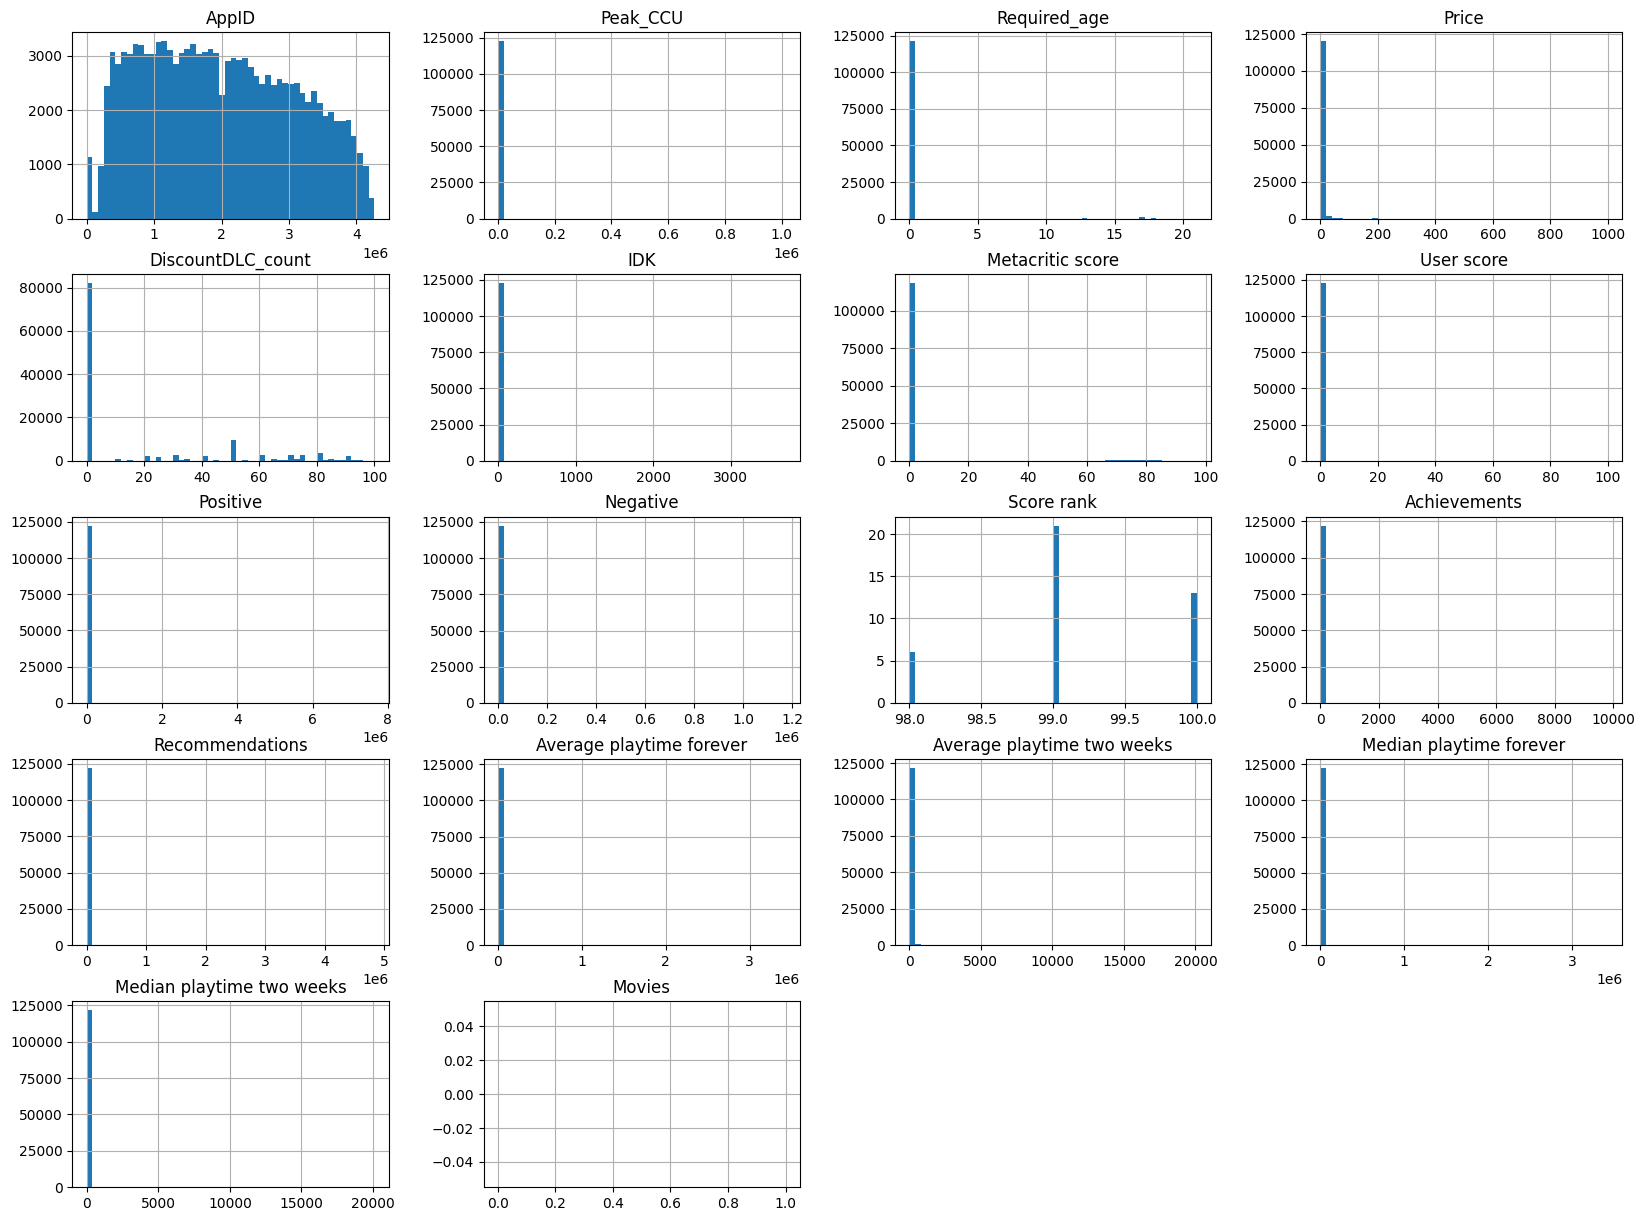

In [4]:
games.hist(bins=50, figsize=(20,15)) 
plt.show()


In [5]:
# creación del training set
def shufle_and_split_data(dataframe, test_ratio):
    shuffled_indices = np.random.permutation(len(dataframe))
    test_set_size = int(len(dataframe) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return dataframe.iloc[train_indices], dataframe.iloc[test_indices]

train_set, test_set = shufle_and_split_data(games, 0.2)
print(f"Rows in train set: {len(train_set)}\nRows in test set: {len(test_set)}")

Rows in train set: 98089
Rows in test set: 24522


In [6]:
from zlib import crc32

# Split data using hash-based approach with game ID
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Reset index to create a stable ID column
games_with_index = games.reset_index()

# Split using the index as ID
train_set_hash, test_set_hash = split_data_with_id_hash(games_with_index, 0.2, 'index')

print(f"Rows in train set: {len(train_set_hash)}\nRows in test set: {len(test_set_hash)}")

Rows in train set: 98090
Rows in test set: 24521


In [7]:
#Parte del entrenamiento
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(games, test_size=0.2, random_state=42)

In [8]:
# 1. Calcular score basado en reviews
# Evitar división por cero
games['Total_reviews'] = games['Positive'] + games['Negative']
games['Score'] = np.where(
    games['Total_reviews'] > 0,
    (games['Positive'] / games['Total_reviews']) * 100,
    np.nan
)

print("✓ Score calculado")
print(f"Score stats:\n{games['Score'].describe()}")

# 2. Crear categorías de score
# Definir rangos (ajusta según tus necesidades)
def categorize_score(score):
    if pd.isna(score):
        return np.nan
    elif score < 40:
        return "Muy Bajo"  # < 40%
    elif score < 60:
        return "Bajo"      # 40-60%
    elif score < 75:
        return "Medio"     # 60-75%
    elif score < 90:
        return "Alto"      # 75-90%
    else:
        return "Muy Alto"  # 90-100%

games['score_cat'] = games['Score'].apply(categorize_score)

print("\n📊 Distribución de categorías:")
print(games['score_cat'].value_counts())
print("\n📈 Proporciones:")
print(games['score_cat'].value_counts(normalize=True))

# 3. Filtrar juegos con suficientes reviews (opcional pero recomendado)
# Solo considerar juegos con al menos 10 reviews para tener scores significativos
min_reviews = 10
games_filtered = games[games['Total_reviews'] >= min_reviews].copy()

print(f"\n🎮 Juegos después de filtrar (>= {min_reviews} reviews): {len(games_filtered)}")
print(f"📊 Distribución de score_cat (filtrado):")
print(games_filtered['score_cat'].value_counts())

✓ Score calculado
Score stats:
count    82949.000000
mean        75.827596
std         23.869120
min          0.000000
25%         64.968153
50%         81.818182
75%         94.444444
max        100.000000
Name: Score, dtype: float64

📊 Distribución de categorías:
score_cat
Muy Alto    28459
Alto        23391
Medio       14307
Bajo         9946
Muy Bajo     6846
Name: count, dtype: int64

📈 Proporciones:
score_cat
Muy Alto    0.343090
Alto        0.281993
Medio       0.172479
Bajo        0.119905
Muy Bajo    0.082533
Name: proportion, dtype: float64

🎮 Juegos después de filtrar (>= 10 reviews): 56655
📊 Distribución de score_cat (filtrado):
score_cat
Alto        19548
Muy Alto    16291
Medio       11600
Bajo         6762
Muy Bajo     2454
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# Filtrar filas sin NaN en score_cat Y con suficientes reviews
games_with_cat = games[
    (games["score_cat"].notna()) & 
    (games['Total_reviews'] >= 10)  # Filtro adicional recomendado
].copy()

print(f"🎯 Juegos válidos para split: {len(games_with_cat)}")
print(f"\n📊 Distribución de categorías:")
print(games_with_cat['score_cat'].value_counts())

# Verificar que cada categoría tenga al menos 2 muestras
category_counts = games_with_cat['score_cat'].value_counts()
min_samples = category_counts.min()

if min_samples < 2:
    print(f"\n⚠️ Advertencia: Algunas categorías tienen menos de 2 muestras")
    print(f"Categorías con pocas muestras:\n{category_counts[category_counts < 2]}")
    
    # Eliminar categorías con menos de 2 muestras
    valid_categories = category_counts[category_counts >= 2].index
    games_with_cat = games_with_cat[games_with_cat['score_cat'].isin(valid_categories)].copy()
    
    print(f"\n✅ Datos filtrados: {len(games_with_cat)} juegos")
    print(f"📊 Distribución actualizada:")
    print(games_with_cat['score_cat'].value_counts())

# Crear el split estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(games_with_cat, games_with_cat["score_cat"]):
    strat_train_set = games_with_cat.iloc[train_index].copy()
    strat_test_set = games_with_cat.iloc[test_index].copy()

print("\n✅ Split completado!")
print(f"📊 Train set: {len(strat_train_set)} juegos")
print(f"📊 Test set: {len(strat_test_set)} juegos")

# Verificar proporciones en ambos conjuntos
print("\n📈 Proporciones en Train Set:")
print(strat_train_set["score_cat"].value_counts(normalize=True).sort_index())

print("\n📈 Proporciones en Test Set:")
print(strat_test_set["score_cat"].value_counts(normalize=True).sort_index())

# Comparar que sean similares
print("\n🔍 Comparación de proporciones:")
comparison = pd.DataFrame({
    'Original': games_with_cat['score_cat'].value_counts(normalize=True),
    'Train': strat_train_set['score_cat'].value_counts(normalize=True),
    'Test': strat_test_set['score_cat'].value_counts(normalize=True)
}).sort_index()
print(comparison)

🎯 Juegos válidos para split: 56655

📊 Distribución de categorías:
score_cat
Alto        19548
Muy Alto    16291
Medio       11600
Bajo         6762
Muy Bajo     2454
Name: count, dtype: int64

✅ Split completado!
📊 Train set: 45324 juegos
📊 Test set: 11331 juegos

📈 Proporciones en Train Set:
score_cat
Alto        0.345027
Bajo        0.119363
Medio       0.204748
Muy Alto    0.287552
Muy Bajo    0.043310
Name: proportion, dtype: float64

📈 Proporciones en Test Set:
score_cat
Alto        0.345071
Bajo        0.119319
Medio       0.204748
Muy Alto    0.287530
Muy Bajo    0.043332
Name: proportion, dtype: float64

🔍 Comparación de proporciones:
           Original     Train      Test
score_cat                              
Alto       0.345036  0.345027  0.345071
Bajo       0.119354  0.119363  0.119319
Medio      0.204748  0.204748  0.204748
Muy Alto   0.287547  0.287552  0.287530
Muy Bajo   0.043315  0.043310  0.043332


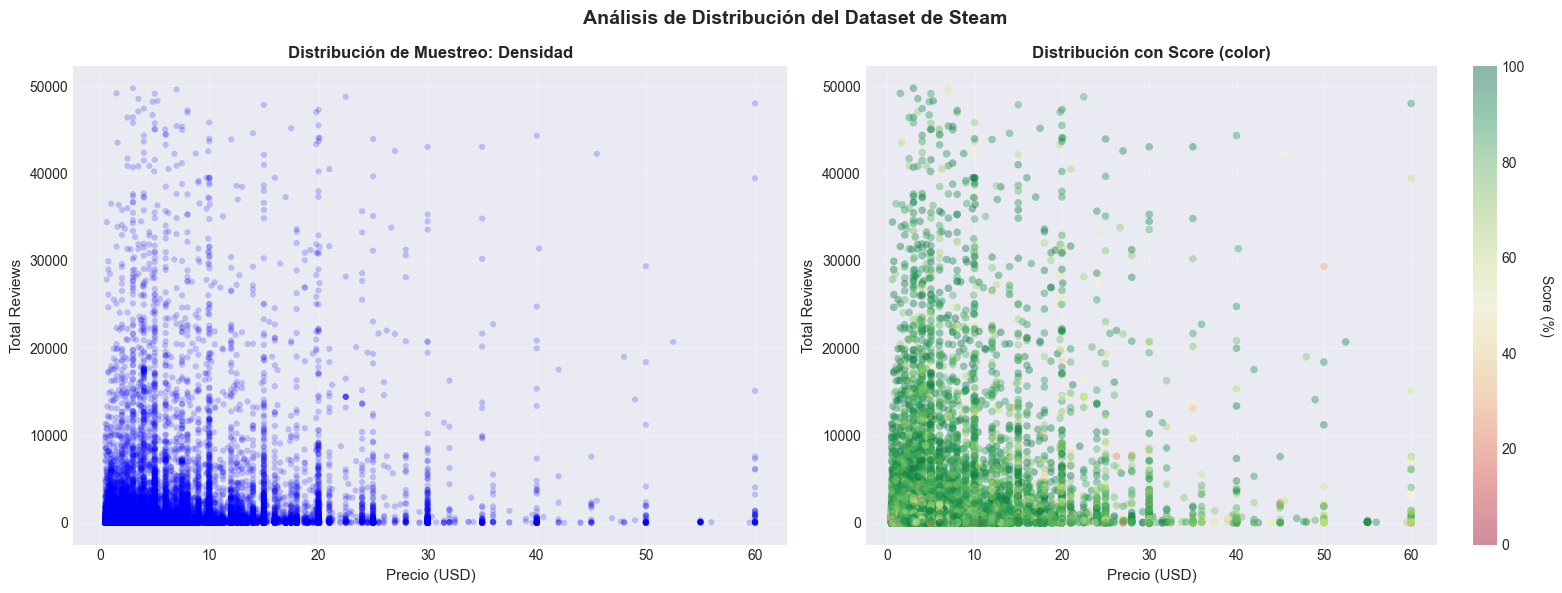

In [10]:
import seaborn as sns
# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# LA MEJOR VISUALIZACIÓN - Combina densidad y categorías
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel izquierdo: Densidad pura (estilo housing)
games_clean = games_with_cat[
    (games_with_cat['Price'] > 0) & 
    (games_with_cat['Price'] < 60) &
    (games_with_cat['Total_reviews'] < 50000)
].copy()

ax1.scatter(
    games_clean['Price'],
    games_clean['Total_reviews'],
    alpha=0.2,
    s=20,
    c='blue',
    edgecolors='none'
)
ax1.set_xlabel('Precio (USD)', fontsize=11)
ax1.set_ylabel('Total Reviews', fontsize=11)
ax1.set_title('Distribución de Muestreo: Densidad', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Panel derecho: Con información de score
scatter = ax2.scatter(
    games_clean['Price'],
    games_clean['Total_reviews'],
    c=games_clean['Score'],
    cmap='RdYlGn',
    alpha=0.4,
    s=30,
    vmin=0,
    vmax=100,
    edgecolors='none'
)
ax2.set_xlabel('Precio (USD)', fontsize=11)
ax2.set_ylabel('Total Reviews', fontsize=11)
ax2.set_title('Distribución con Score (color)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Score (%)', rotation=270, labelpad=20)

games = games_clean

plt.suptitle('Análisis de Distribución del Dataset de Steam', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Como nuestro muestreo es corto, podemos calcular la correlación de Pearson directamente
# Excluimos las columnas no numéricas (p. ej. 'Name') antes de calcular la correlación
numeric_games = games.select_dtypes(include=[np.number])
corr_matrix = numeric_games.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price                         1.000000
Score rank                    0.363900
Negative                      0.137039
Total_reviews                 0.134382
Recommendations               0.132071
Positive                      0.126955
IDK                           0.069000
Median playtime two weeks     0.066470
Peak_CCU                      0.064994
Required_age                  0.064146
Average playtime two weeks    0.063451
Average playtime forever      0.062771
Median playtime forever       0.058767
Metacritic score              0.055491
Score                         0.043267
AppID                         0.035769
User score                   -0.001205
Achievements                 -0.022109
DiscountDLC_count            -0.249004
Movies                             NaN
Name: Price, dtype: float64

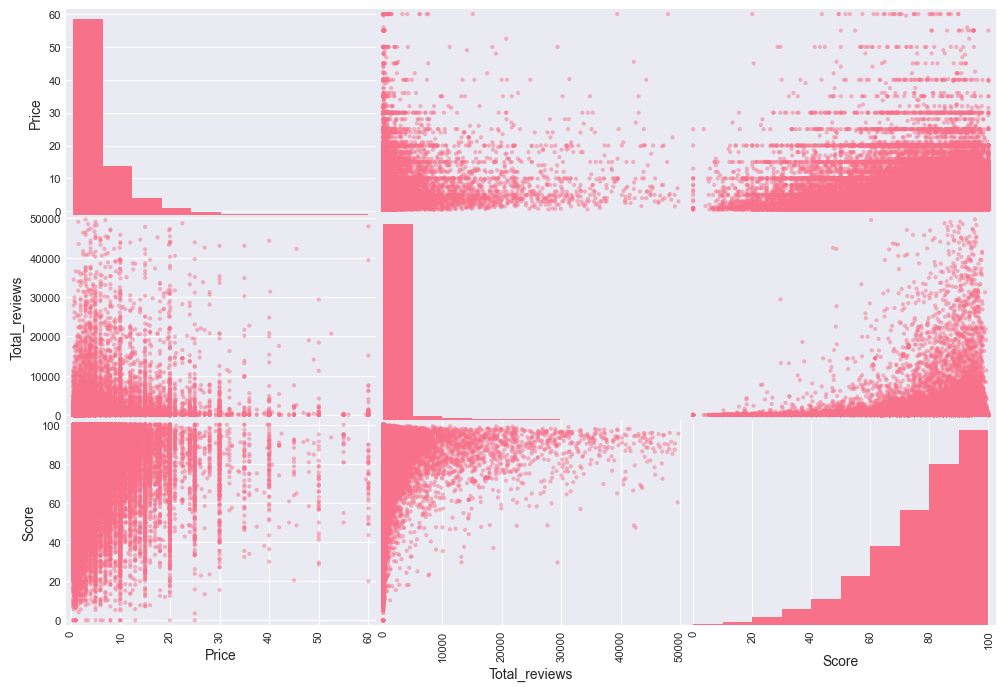

In [12]:
# Podemos ver la correlacion de otra forma a traves de un scatter matrix
from pandas.plotting import scatter_matrix

attributes = ["Price", "Total_reviews", "Score"]
scatter_matrix(games[attributes], figsize=(12, 8))
plt.show()

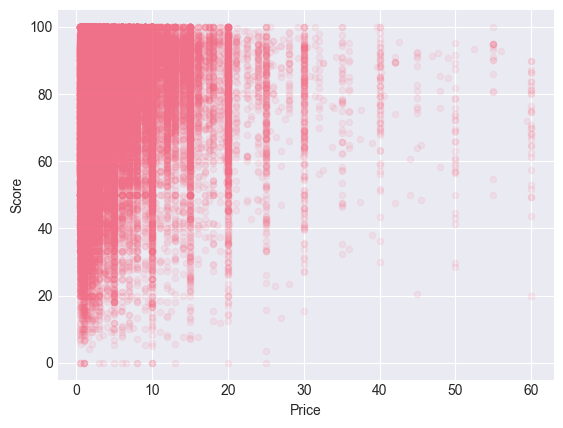

In [13]:
games.plot(kind="scatter", x="Price", y="Score", alpha=0.1)
plt.show()

In [14]:
# Podemos ver algunas correlaciones interesantes
numeric_games = games.select_dtypes(include=[np.number])
# usar solo las columnas numéricas para evitar errores con columnas de texto (p. ej. 'Movies')
corr_matrix = numeric_games.corr()
corr_matrix["Score"].sort_values(ascending=False)

Score                         1.000000
Score rank                    0.929057
AppID                         0.241944
Positive                      0.117194
Total_reviews                 0.097282
Recommendations               0.095348
Metacritic score              0.060542
Price                         0.043267
Median playtime two weeks     0.025324
Average playtime two weeks    0.023928
Peak_CCU                      0.021214
Average playtime forever      0.016215
Median playtime forever       0.010994
User score                    0.005631
IDK                           0.004389
DiscountDLC_count            -0.000686
Achievements                 -0.011252
Required_age                 -0.017617
Negative                     -0.029628
Movies                             NaN
Name: Score, dtype: float64

In [15]:
# Crearemos nuevas caracteristicas 
games["year"] = pd.DatetimeIndex(games['Release_date']).year
games["age"] = 2025 - games["year"]

In [16]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# Seleccionar solo columnas numéricas porque SimpleImputer solo funciona con datos numéricos
numeric_games = games.select_dtypes(include=[np.number]).drop(columns=["Movies"])
imputer.fit(numeric_games)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [17]:
print("características usadas para el imputer:", numeric_games.columns.tolist())
print(imputer.statistics_)
print(numeric_games.median().values)

características usadas para el imputer: ['AppID', 'Peak_CCU', 'Required_age', 'Price', 'DiscountDLC_count', 'IDK', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Total_reviews', 'Score', 'year', 'age']
[1.24959500e+06 0.00000000e+00 0.00000000e+00 3.59000000e+00
 2.50000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.40000000e+01 1.20000000e+01 9.90000000e+01 1.20000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.90000000e+01 8.18181818e+01 2.02100000e+03
 4.00000000e+00]
[1.24959500e+06 0.00000000e+00 0.00000000e+00 3.59000000e+00
 2.50000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.40000000e+01 1.20000000e+01 9.90000000e+01 1.20000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.90000000e+01 8.18181818e+01 2.02100000e

In [18]:
# Con el imputer entrenado, podemos transformar el conjunto de datos para completar los valores faltantes

x = imputer.transform(numeric_games)

In [19]:
# En nuestro caso, el resultado es una matriz NumPy, así que debemos convertirla de nuevo a un DataFrame    

games_tr = pd.DataFrame(x, columns=numeric_games.columns, index=numeric_games.index)

In [20]:
# Demos un vistazo al atributo categórico 'Categories'
games_cat = games[["Categories"]]
print(games_cat.head(10))

                                           Categories
1   Single-player,Steam Trading Cards,Steam Cloud,...
2                        Single-player,Family Sharing
6   Single-player,Steam Workshop,Steam Cloud,Famil...
8   Single-player,Steam Achievements,Full controll...
9   Single-player,Steam Achievements,Full controll...
11                       Single-player,Family Sharing
12  Single-player,Multi-player,PvP,Online PvP,Stea...
13  Single-player,Steam Achievements,Partial Contr...
14  Single-player,Steam Achievements,Full controll...
17                       Single-player,Family Sharing


In [21]:
# Vamos a convertir estas categorías de texto en números usando OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
games_cat_encoded = ordinal_encoder.fit_transform(games_cat)
print(games_cat_encoded[:10])

# lista de categorías
print(ordinal_encoder.categories_)

[[6013.]
 [ 646.]
 [6049.]
 [4782.]
 [4825.]
 [ 646.]
 [3287.]
 [5407.]
 [4830.]
 [ 646.]]
[array(['Adjustable Text Size,Color Alternatives,Custom Volume Controls,Keyboard Only Option,Mouse Only Option,Narrated Game Menus,Playable without Timed Input,Save Anytime,Stereo Sound,Touch Only Option',
       'Adjustable Text Size,Color Alternatives,Playable without Timed Input,Save Anytime,Family Sharing',
       'Captions available,Steam Workshop,Partial Controller Support,Steam Cloud',
       ..., 'VR Supported,Partial Controller Support',
       'VR Supported,Steam Workshop,Partial Controller Support', nan],
      shape=(6215,), dtype=object)]


In [22]:
# Para una representación one-hot, usamos OneHotEncoder, esto crea una columna binaria para cada categoría y evitar que el modelo interprete un orden entre las categorías
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
games_cat_onehot = one_hot_encoder.fit_transform(games_cat)
print(games_cat_onehot.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
# Ahora veamos cómo manejar la columna categórica 'Categories', con un estimador personalizado y ColumnTransformer
games_test = pd.DataFrame({
    'Categories': ['Adjustable Text Size,Color Alternatives,Playable without Timed Input,Save Anytime,Family Sharing',
       'Captions available,Steam Workshop,Partial Controller Support,Steam Cloud',
       'Family Sharing', ..., 'VR Supported,Partial Controller Support',
       'VR Supported,Steam Workshop,Partial Controller Support']
})

one_hot_encoder.handle_unknown = "ignore"
one_hot_encoder.transform(games_test)

print(one_hot_encoder.feature_names_in_)
print(one_hot_encoder.get_feature_names_out())

# Crear un DataFrame con los resultados one-hot
games_output = pd.DataFrame(one_hot_encoder.transform(games_test).toarray(),
                         columns=one_hot_encoder.get_feature_names_out(),
                         index=games_test.index)

print("Dataframe: ", games_output)

['Categories']
['Categories_Adjustable Text Size,Color Alternatives,Custom Volume Controls,Keyboard Only Option,Mouse Only Option,Narrated Game Menus,Playable without Timed Input,Save Anytime,Stereo Sound,Touch Only Option'
 'Categories_Adjustable Text Size,Color Alternatives,Playable without Timed Input,Save Anytime,Family Sharing'
 'Categories_Captions available,Steam Workshop,Partial Controller Support,Steam Cloud'
 ... 'Categories_VR Supported,Partial Controller Support'
 'Categories_VR Supported,Steam Workshop,Partial Controller Support'
 'Categories_nan']
Dataframe:     Categories_Adjustable Text Size,Color Alternatives,Custom Volume Controls,Keyboard Only Option,Mouse Only Option,Narrated Game Menus,Playable without Timed Input,Save Anytime,Stereo Sound,Touch Only Option  ...  Categories_nan
0                                                0.0                                                                                                                                          

In [24]:
# Veremos como usar el minmaxscaler para escalar las características numéricas, esto nos permite transformar las características para que estén en un rango específico, generalmente entre 0 y 1.
from sklearn.preprocessing import MinMaxScaler

# Crear el MinMaxScaler con un rango personalizado, por ejemplo entre -1 y 1, esto nos permite ajustar el rango de los datos según nuestras necesidades.
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
games_num_min_max_scaled = min_max_scaler.fit_transform(numeric_games)

In [25]:
# Otro camino es usar StandardScaler, que estandariza las características eliminando la media y escalándolas a la varianza unitária
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
games_num_std_scaled = standard_scaler.fit_transform(numeric_games)

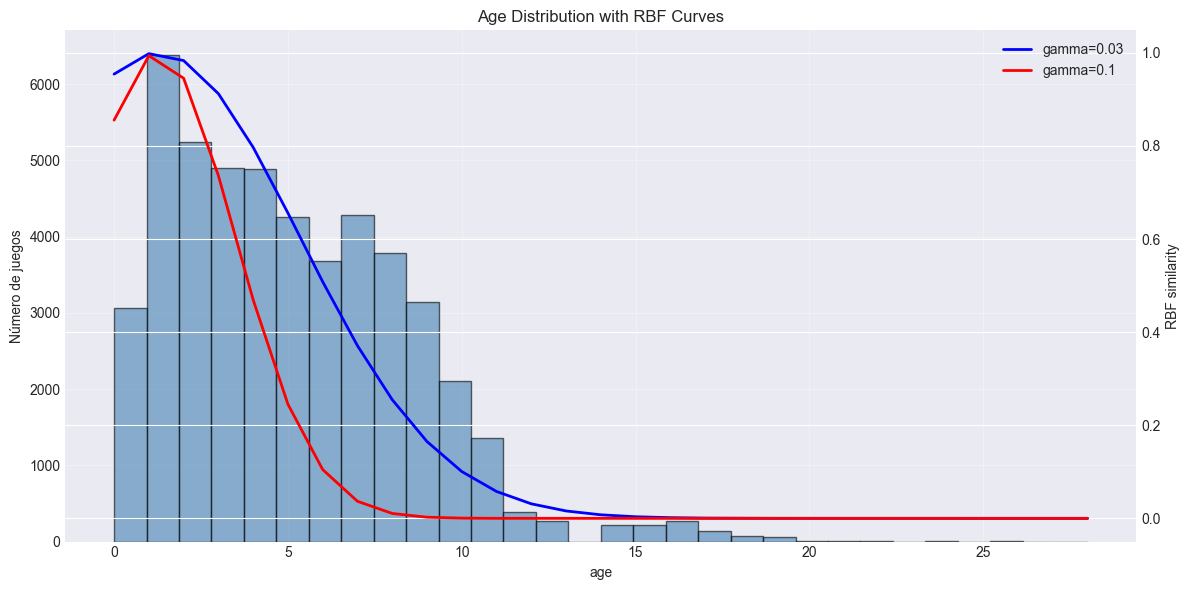

In [26]:
# Una forma de ver la función de base radial(RBF), que es comúnmente usada en máquinas de vectores de soporte y redes neuronales es a través de la fórmula matemática:
def rbf(x, c, s):
    return np.exp(-((x - c) ** 2) / (2 * s ** 2))

# Nosotros la podemos usar para transformar una característica numérica en una representación basada en RBFs.
from sklearn.metrics.pairwise import rbf_kernel

# Calcular la similitud RBF de la característica 'age' con respecto a un centro específico (por ejemplo, 1.25) y diferentes valores de gamma, gamma controla la anchura de la campana RBF.
age_simil_4 = rbf_kernel(numeric_games[["age"]], [[1.25]], gamma=0.03)
age_4 = rbf_kernel(numeric_games[["age"]], [[1.25]], gamma=0.1)

# Ordenar los datos por edad para graficar líneas suaves
sorted_indices = np.argsort(numeric_games["age"].values.flatten())
sorted_age = numeric_games["age"].values[sorted_indices]
sorted_simil_4 = age_simil_4[sorted_indices]
sorted_age_4 = age_4[sorted_indices]

fig, ax = plt.subplots(figsize=(12, 6))

# Gráfico RBF con diferentes gammas superpuesto al histograma
ax.hist(numeric_games["age"], bins=30, color='steelblue', edgecolor='black', alpha=0.6, density=False)
ax2 = ax.twinx()
ax2.plot(sorted_age, sorted_simil_4, "b-", linewidth=2, label="gamma=0.03")
ax2.plot(sorted_age, sorted_age_4, "r-", linewidth=2, label="gamma=0.1")
ax.set_xlabel("age")
ax.set_ylabel("Número de juegos")
ax2.set_ylabel("RBF similarity")
ax.set_title("Age Distribution with RBF Curves")
ax2.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
games_labels = strat_train_set["Price"].copy()

In [28]:
# Otra forma de hacer esto es usando TransformedTargetRegressor de sklearn, que maneja automáticamente la transformación de las etiquetas durante el entrenamiento y la predicción.
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

# Escala los valores objetivo (etiquetas) a media 0 y desviación estándar 1
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(games_labels.to_frame())

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
# Obtiene 5 muestras de nuevos datos
some_new_data = strat_train_set[["Price"]].iloc[:5]

model.fit(strat_train_set[["Price"]], games_labels)
final_preds = model.predict(some_new_data)
print(final_preds)

[ 5.59  3.24 19.99  4.99  1.99]


In [29]:
from sklearn.preprocessing import FunctionTransformer

# Una transformación logarítmica puede ser útil para características con una distribución sesgada
def log_transform(x):
    return np.log(x + 1)  # Agregar 1 para evitar log(0)

# usar FunctionTransformer para aplicar la transformación logarítmica
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
log_pop = log_transformer.fit_transform(games[["Median playtime forever"]])
print(log_pop[:5])

   Median playtime forever
1                 2.197225
2                 0.000000
6                 7.134094
8                 0.000000
9                 0.000000


In [30]:
# Podemos crear transformaciones personalizadas más complejas usando FunctionTransformer
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[1.25]], gamma=0.1))
age_simil_125 = rbf_transformer.fit_transform(games[["age"]])
print('Similaridad con edad 1.25:', age_simil_125[:5])

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.fit_transform(games[["Price", "Score"]])
print('Similaridad entre juegos:', sf_simil[:5])

ratio_transformer = FunctionTransformer(lambda x: x[:, 0] / x[:, 1]) # total_bedrooms / total_rooms
print('Similaridad de ratio:', ratio_transformer.transform(np.array([[1.,2], [3.,4.]])))

Similaridad con edad 1.25: [[0.00246331]
 [0.10474253]
 [0.85534533]
 [0.46942347]
 [0.46942347]]
Similaridad entre juegos: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Similaridad de ratio: [0.5  0.75]


In [31]:
# Crearemos nuestro clon de un scaler standard, esto es útil para entender cómo funcionan los transformadores en sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None): # y es opcional, se incluye para compatibilidad con pipelines
        X = check_array(X) # Validar la entrada
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.n_features_in_ = X.shape[1] # Número de características, necesario para la validación
        return self # devolver el objeto entrenado

    def transform(self, X):
        check_is_fitted(self) # Verificar si el transformador ha sido entrenado
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1], ("El número de características no coincide con el del entrenamiento.")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [32]:
# También podemos realizar nuestro cluster personalizado usando KMeans
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin): # Transforma características basadas en la similitud a centros de clústeres
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None): # y es opcional, se incluye para compatibilidad con pipelines
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X): # Calcular la similitud RBF entre los puntos de datos y los centros de clústeres
        check_is_fitted(self)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma) # Devolver como columna
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster_{i} Similarity" for i in range(self.n_clusters)]

In [33]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42) # Crear el transformador de similitud de clústeres
similarities = cluster_simil.fit_transform(strat_train_set[["Price", "Score"]], 
                                           sample_weight=games_labels)

In [34]:
print(similarities[:3].round(2)) # Mostrar las primeras 3 filas de similitudes redondeadas a 2 decimales

[[0.13 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


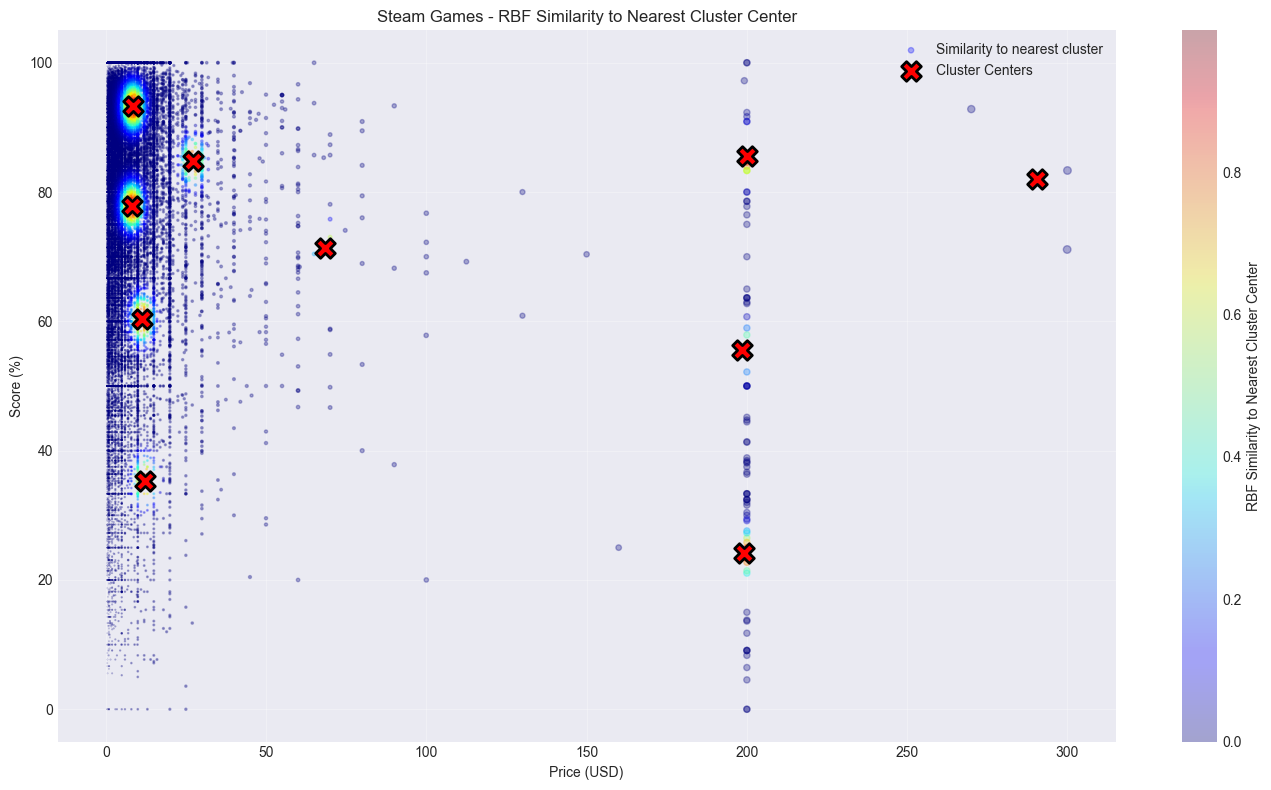

In [35]:
# Visualizar el mapa con colores según la similitud al centro de clúster más cercano
# Obtener la similitud máxima (al clúster más cercano) para cada juego
max_cluster_similarity = similarities.max(axis=1)

# Crear el gráfico
plt.figure(figsize=(14, 8))
plt.scatter(strat_train_set["Price"], strat_train_set["Score"], 
            c=max_cluster_similarity, 
            cmap='jet', 
            alpha=0.3,
            s=games_labels/10,  # Tamaño basado en el precio objetivo
            label='Similarity to nearest cluster')
plt.colorbar(label='RBF Similarity to Nearest Cluster Center')
plt.xlabel('Price (USD)')
plt.ylabel('Score (%)')
plt.title('Steam Games - RBF Similarity to Nearest Cluster Center')
plt.legend()
plt.grid(True, alpha=0.3)

# Marcar los centros de los clústeres
cluster_centers = cluster_simil.kmeans_.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
            c='red', 
            marker='X', 
            s=200, 
            edgecolors='black',
            linewidths=2,
            label='Cluster Centers',
            zorder=5)

plt.legend()
plt.tight_layout()
plt.show()

In [36]:
from sklearn.pipeline import Pipeline, make_pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy="median")),
    ('standardize', StandardScaler()),
])

n_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

In [37]:
games_num_prepares = num_pipeline.fit_transform(numeric_games)
print(games_num_prepares[:5].round(2))

[[-1.03 -0.04 -0.13 -0.03  1.01 -0.06 -0.28 -0.02 -0.16 -0.22 -0.01 -0.14
  -0.16 -0.08 -0.06 -0.08 -0.07 -0.18  1.18 -1.13  1.13]
 [-0.42 -0.04 -0.13 -0.08 -0.95 -0.06 -0.28 -0.02 -0.23 -0.22 -0.01 -0.14
  -0.23 -0.09 -0.06 -0.08 -0.07 -0.24  0.55 -0.29  0.29]
 [ 0.61 -0.03 -0.13  5.14 -0.65  0.02 -0.28 -0.02 -0.2  -0.2  -0.01 -0.14
  -0.19  0.11 -0.06  0.3  -0.07 -0.21  0.69  1.4  -1.4 ]
 [-0.28 -0.04 -0.13 -0.75 -0.95 -0.06 -0.28 -0.02 -0.23 -0.22 -0.01 -0.1
  -0.23 -0.09 -0.06 -0.08 -0.07 -0.24  0.55  0.28 -0.28]
 [ 0.16 -0.04 -0.13 -0.82 -0.95  0.02 -0.28 -0.02 -0.23 -0.21 -0.01  0.32
  -0.23 -0.09 -0.06 -0.08 -0.07 -0.24 -0.08  0.28 -0.28]]


In [42]:
df_games_num_prepares = pd.DataFrame(games_num_prepares, 
                                     columns=num_pipeline.get_feature_names_out(),
                                     index=numeric_games.index)
print(df_games_num_prepares.head(2).round(2))

   AppID  Peak_CCU  Required_age  Price  ...  Total_reviews  Score  year   age
1  -1.03     -0.04         -0.13  -0.03  ...          -0.18   1.18 -1.13  1.13
2  -0.42     -0.04         -0.13  -0.08  ...          -0.24   0.55 -0.29  0.29

[2 rows x 21 columns]


In [55]:
from sklearn.compose import ColumnTransformer

num_attribs = list(numeric_games.columns)
cat_attribs = ["Categories"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
], sparse_threshold=0)  # sparse_threshold=0 fuerza salida densa (ndarray)

In [58]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing_selector = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    sparse_threshold=0,  # Retorna ndarray denso
    remainder='drop'  # Descartar columnas no seleccionadas
)

games_prepared = preprocessing_selector.fit_transform(games[num_attribs + cat_attribs])
print(games_prepared[:2])

[[-1.03087752 -0.04210755 -0.12862785 ...  0.          0.
   0.        ]
 [-0.4167202  -0.04210755 -0.12862785 ...  0.          0.
   0.        ]]
